Calories dataset:
    User_ID  Calories
0  14733363     231.0
1  14861698      66.0
2  11179863      26.0
3  16180408      71.0
4  17771927      35.0

Exercise dataset:
    User_ID  Gender  Age  Height  Weight  Duration  Heart_Rate  Body_Temp
0  14733363    male   68   190.0    94.0      29.0       105.0       40.8
1  14861698  female   20   166.0    60.0      14.0        94.0       40.3
2  11179863    male   69   179.0    79.0       5.0        88.0       38.7
3  16180408  female   34   179.0    71.0      13.0       100.0       40.5
4  17771927  female   27   154.0    58.0      10.0        81.0       39.8

Missing values:
User_ID       0
Gender        0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

Number of duplicate rows: 0

Number of rows after cleaning outliers: 14993 (original: 15000)
Cleaned data saved.


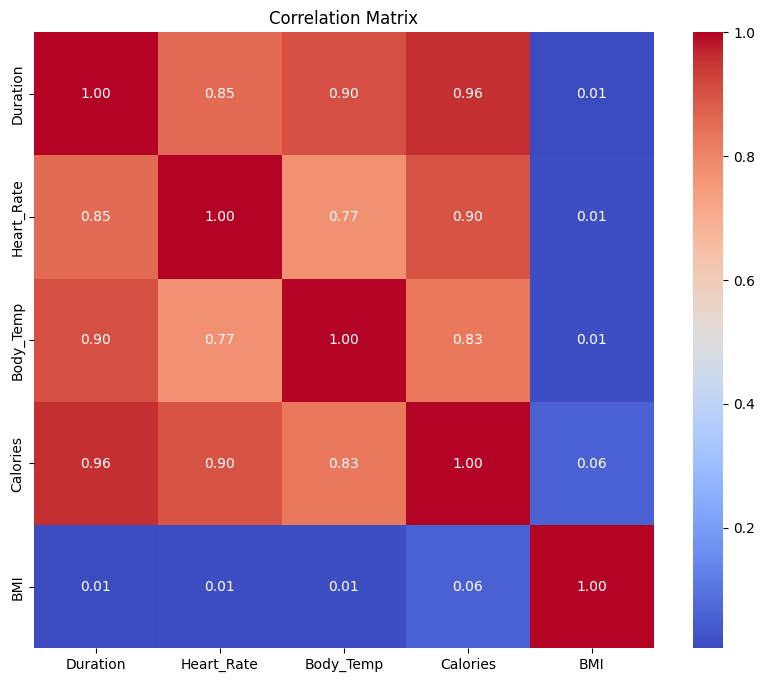

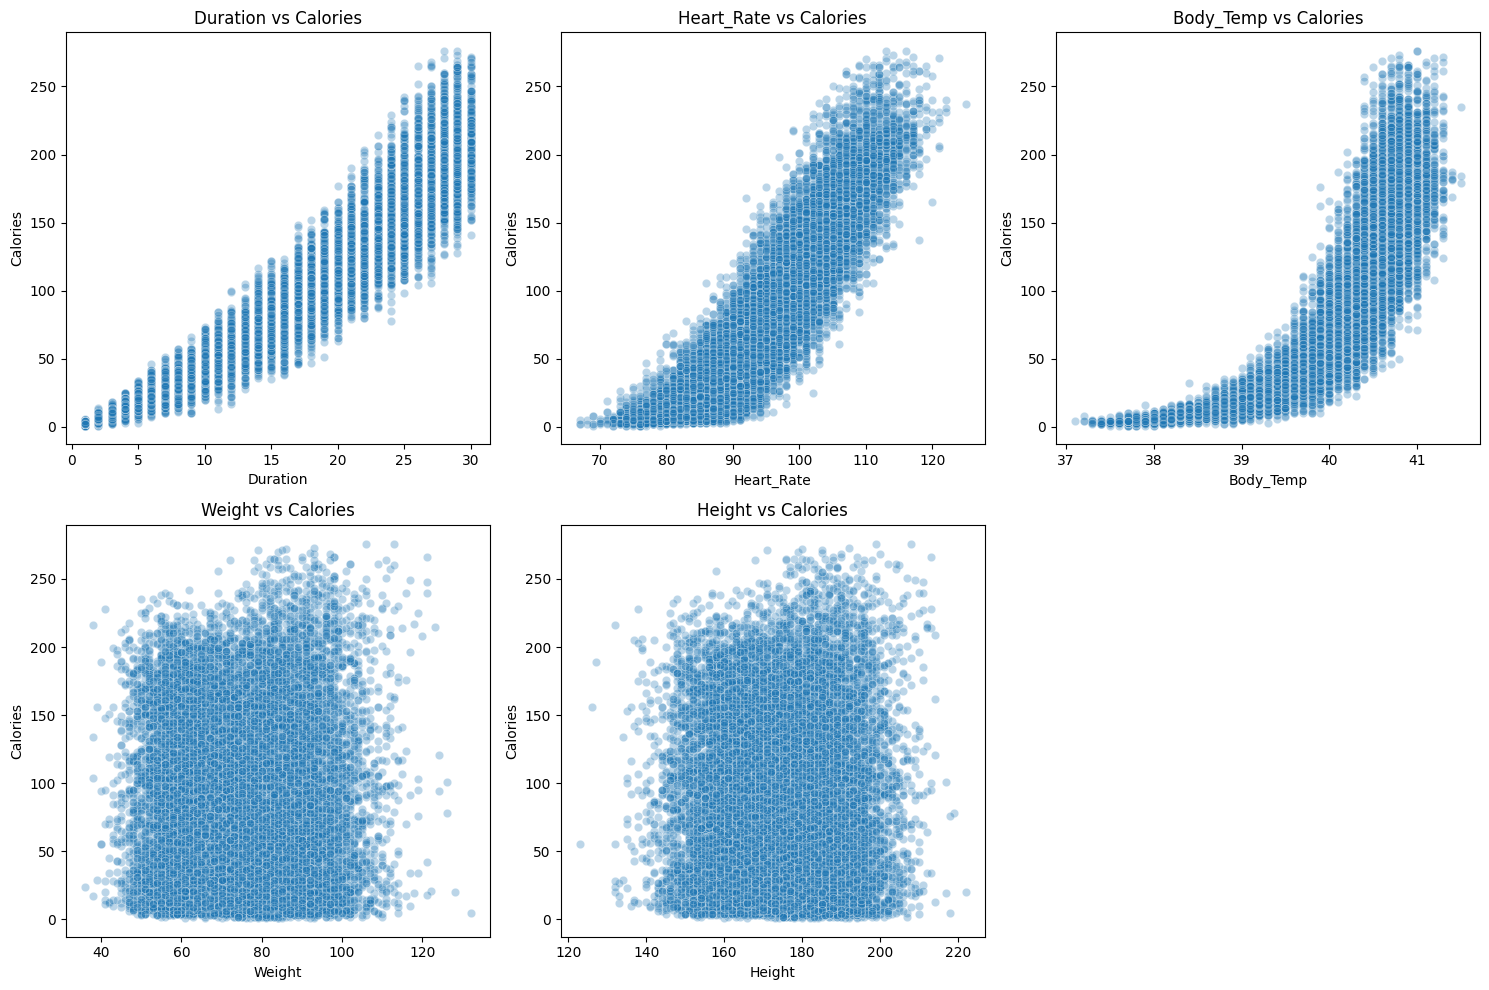

<ipython-input-3-d879ae0fa741>:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['ID_Group'] = pd.cut(df_cleaned['User_ID'], bins=bins, labels=labels)
<ipython-input-3-d879ae0fa741>:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_calories = df_cleaned.groupby('ID_Group')['Calories'].mean()


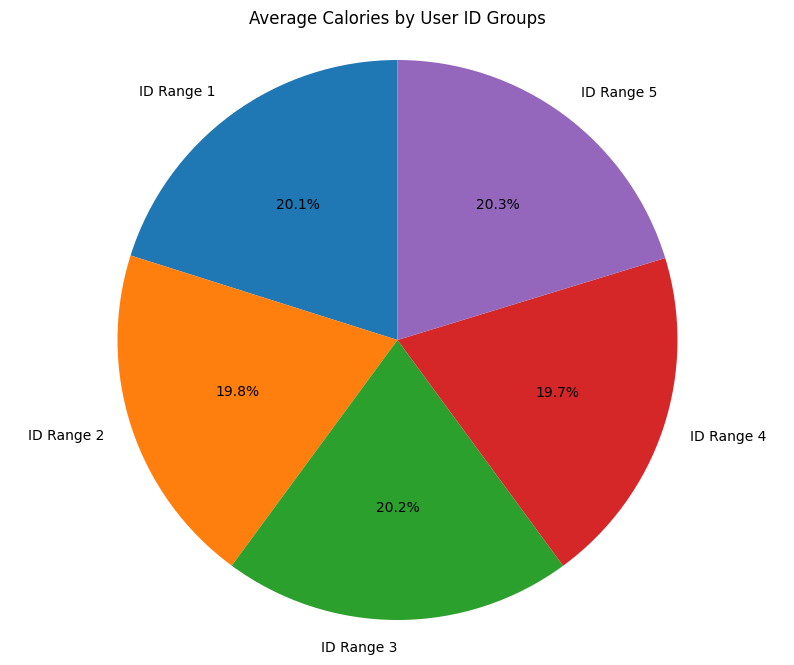

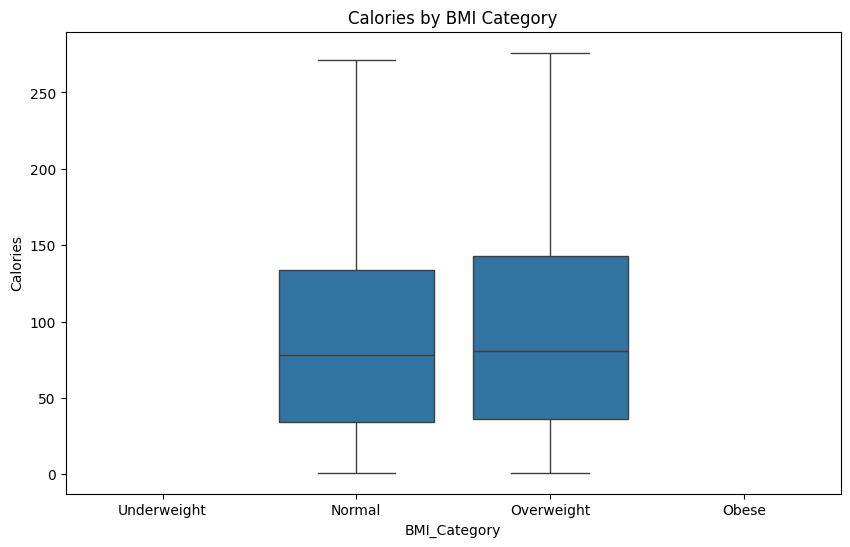

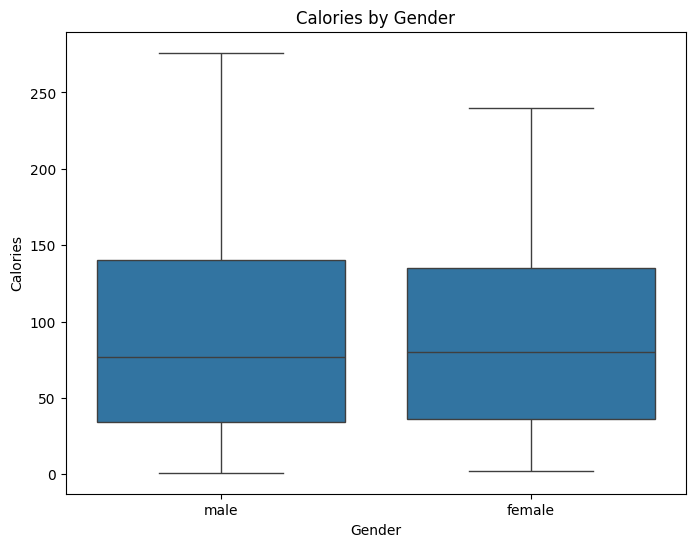

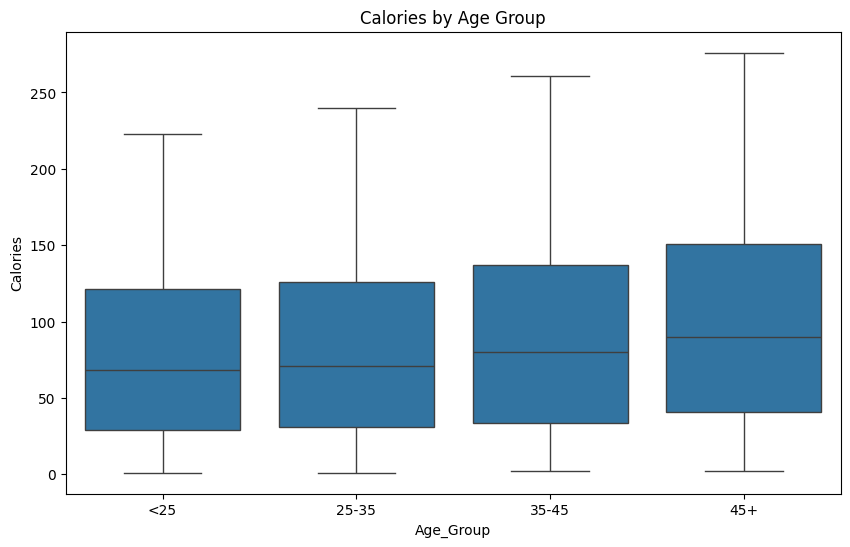

<ipython-input-3-d879ae0fa741>:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Calories_per_Minute'] = df_cleaned['Calories'] / df_cleaned['Duration']


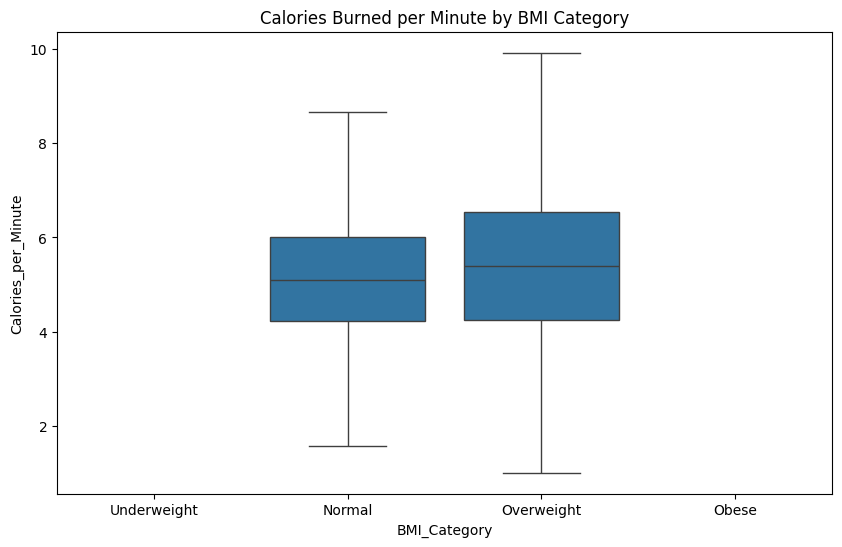

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Read CSV files
calories_df = pd.read_csv('calories.csv.xls')
exercise_df = pd.read_csv('exercise.csv.xls')

# Check first few rows
print("Calories dataset:")
print(calories_df.head())

print("\nExercise dataset:")
print(exercise_df.head())

# Merge the two datasets
df = pd.merge(exercise_df, calories_df, on='User_ID')

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# 1. Clean NULL values: Fill with the mean of each column
for column in df.columns:
    if df[column].isnull().sum() > 0:
        df[column].fillna(df[column].mean(), inplace=True)

# Check and remove duplicate values
duplicate_rows = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicate_rows}")
df = df.drop_duplicates()

# Calculate BMI
if 'Weight' in df.columns and 'Height' in df.columns:
    df['BMI'] = df['Weight'] / ((df['Height']/100) ** 2)

    # Create BMI categories
    df['BMI_Category'] = pd.cut(df['BMI'],
                          bins=[0, 18.5, 25, 30, 100],
                          labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

# Create age groups
if 'Age' in df.columns:
    df['Age_Group'] = pd.cut(df['Age'],
                        bins=[0, 25, 35, 45, 100],
                        labels=['<25', '25-35', '35-45', '45+'])

# Identify and remove outliers (using Z-score method)
def remove_outliers(df, column, z_threshold=3):
    z_scores = stats.zscore(df[column])
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < z_threshold)
    return df[filtered_entries]

# Clean outliers for Calories
df_cleaned = remove_outliers(df, 'Calories')
print(f"\nNumber of rows after cleaning outliers: {len(df_cleaned)} (original: {len(df)})")

# Save processed data
df_cleaned.to_csv('processed_fitness_data_cleaned.csv', index=False)
print("Cleaned data saved.")

# 2. Correlation Matrix (simplified)
selected_columns = ['Duration', 'Heart_Rate', 'Body_Temp', 'Calories', 'BMI']
correlation_matrix = df_cleaned[selected_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.savefig('simplified_correlation_matrix.png')
plt.show()

# 3. Transparent Scatter Plots
plt.figure(figsize=(15, 10))
for i, col in enumerate(['Duration', 'Heart_Rate', 'Body_Temp', 'Weight', 'Height']):
    plt.subplot(2, 3, i+1)
    sns.scatterplot(x=df_cleaned[col], y=df_cleaned['Calories'], alpha=0.3)  # alpha for transparency
    plt.title(f'{col} vs Calories')
plt.tight_layout()
plt.savefig('transparent_scatter_plots.png')
plt.show()

# 4. User ID - Calories Pie Chart
# Divide IDs into equal intervals
min_id = df_cleaned['User_ID'].min()
max_id = df_cleaned['User_ID'].max()
id_range = max_id - min_id
bins = [min_id + (id_range / 5) * i for i in range(6)]
labels = [f'ID Range {i+1}' for i in range(5)]

df_cleaned['ID_Group'] = pd.cut(df_cleaned['User_ID'], bins=bins, labels=labels)

# Calculate average calories for each group
group_calories = df_cleaned.groupby('ID_Group')['Calories'].mean()

plt.figure(figsize=(10, 8))
plt.pie(group_calories, labels=group_calories.index, autopct='%1.1f%%', startangle=90)
plt.title('Average Calories by User ID Groups')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.savefig('user_id_calories_pie.png')
plt.show()

# 5. Box Plots with Cleaned Data (no visible outliers)
# By BMI category
plt.figure(figsize=(10, 6))
sns.boxplot(x='BMI_Category', y='Calories', data=df_cleaned, showfliers=False)
plt.title('Calories by BMI Category')
plt.savefig('calories_by_bmi_cleaned.png')
plt.show()

# By gender
if 'Gender' in df_cleaned.columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Gender', y='Calories', data=df_cleaned, showfliers=False)
    plt.title('Calories by Gender')
    plt.savefig('calories_by_gender_cleaned.png')
    plt.show()

# By age group
plt.figure(figsize=(10, 6))
sns.boxplot(x='Age_Group', y='Calories', data=df_cleaned, showfliers=False)
plt.title('Calories by Age Group')
plt.savefig('calories_by_age_cleaned.png')
plt.show()

# Bonus: Calories Burned per Minute by BMI Category
df_cleaned['Calories_per_Minute'] = df_cleaned['Calories'] / df_cleaned['Duration']
plt.figure(figsize=(10, 6))
sns.boxplot(x='BMI_Category', y='Calories_per_Minute', data=df_cleaned, showfliers=False)
plt.title('Calories Burned per Minute by BMI Category')
plt.savefig('calories_per_minute_by_bmi.png')
plt.show()